## Libraries Used

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

## Import the Dataset

In [2]:
df = pd.read_csv('dataset/Bengaluru_House_Data.csv')

In [3]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


## Exploratory Data Analysis

There are 13320 observations in the dataset with each having 9 columns. 8 of them are predictor variables and 1 being target variable [Price].

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


-------------------------------------------
Location, Size, Society, Bath and Balcony features have missing values. But number of missing values for location, size, bath and balcony are not much. Society has maximum missing values and we need to decide whether to drop the feature or imput it.

In [5]:
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [6]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [7]:
df.describe(include=['O'])

,area_type,availability,location,size,society,total_sqft
count,13320,13320,13319,13304,7818,13320
unique,4,81,1305,31,2688,2117
top,Super built-up Area,Ready To Move,Whitefield,2 BHK,GrrvaGr,1200
freq,8790,10581,540,5199,80,843


-------
There are four different type of areas with 'Super built-up Area' having the maximum count. And there are no missing values. We can convert this feature into dummy variables.

In [8]:
# count of various area types
df['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

<AxesSubplot:xlabel='area_type', ylabel='count'>

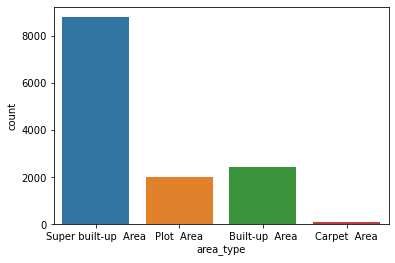

In [9]:
sns.countplot(x='area_type', data=df)

----
There are 81 different types of values for 'availability'. And for me this feature won't be useful in deciding the price of a house. So we will drop it in the data cleaning step

In [10]:
df['availability'].value_counts()

Ready To Move    10581
18-Dec             307
18-May             295
18-Apr             271
18-Aug             200
                 ...  
16-Jan               1
17-Jan               1
16-Oct               1
14-Jul               1
16-Nov               1
Name: availability, Length: 81, dtype: int64

------
There are 4 different values for balconies a house has. 2 and 1 being the most common ones. There are many houses that do not have a balcony and there are 609 missing values. This number is comparatively less than the total number of observations, hence, we can drop those observations.

In [11]:
df['balcony'].value_counts()

2.0    5113
1.0    4897
3.0    1672
0.0    1029
Name: balcony, dtype: int64

<AxesSubplot:xlabel='balcony', ylabel='count'>

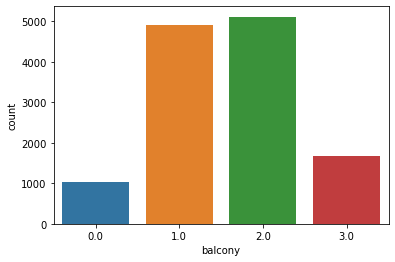

In [12]:
sns.countplot(x='balcony', data=df)

<AxesSubplot:xlabel='price', ylabel='Count'>

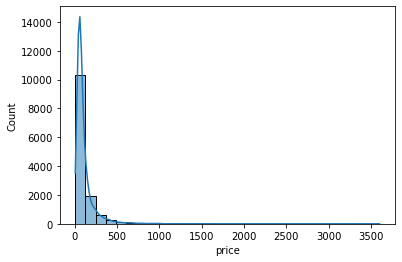

In [13]:
# distribution of price variable
sns.histplot(x='price', data=df, kde=True, bins=30)

---
Size variable has lot of different values which is not required at all. Also there are lot of outliers

In [14]:
df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', nan, '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

---
There are 2688 different 'society' values with 1524 having a single observation. So I have decided to drop it.

In [15]:
df['society'].value_counts()

GrrvaGr    80
PrarePa    76
Prtates    59
Sryalan    59
GMown E    56
           ..
Nae 2El     1
Sithand     1
Skesta      1
Siiewag     1
Krberl      1
Name: society, Length: 2688, dtype: int64

In [16]:
sum(df['society'].value_counts() == 1)

1524

----
There seemed to be a lot of outliers in for bath observation. It needs to worked on

In [17]:
df['bath'].value_counts()

2.0     6908
3.0     3286
4.0     1226
1.0      788
5.0      524
6.0      273
7.0      102
8.0       64
9.0       43
10.0      13
12.0       7
13.0       3
11.0       3
16.0       2
27.0       1
18.0       1
40.0       1
15.0       1
14.0       1
Name: bath, dtype: int64

<AxesSubplot:xlabel='bath', ylabel='count'>

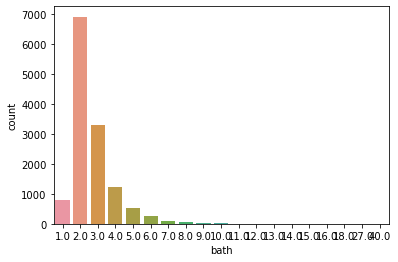

In [18]:
sns.countplot(x='bath', data=df)

---
'total_sqft' require a lot of cleaning. Firstly these are objects, secondly there are ranges given which needs to be converted into single number.

In [19]:
df['total_sqft']

0        1056
1        2600
2        1440
3        1521
4        1200
         ... 
13315    3453
13316    3600
13317    1141
13318    4689
13319     550
Name: total_sqft, Length: 13320, dtype: object

In [32]:
df['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

## Data Cleaning

Decided to drop Availability, society

In [20]:
df.drop(['availability', 'society'], axis=1, inplace = True)

In [21]:
df.head()

,area_type,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Built-up Area,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Super built-up Area,Kothanur,2 BHK,1200,2.0,1.0,51.00


In [22]:
df.isnull().sum()

area_type       0
location        1
size           16
total_sqft      0
bath           73
balcony       609
price           0
dtype: int64

--- 
Decided to drop observations having missing value. A total of 610 observations were dropped which is relatively smaller compared to the size of the dataset.

In [23]:
df.dropna(inplace=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12710 entries, 0 to 13319
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area_type   12710 non-null  object 
 1   location    12710 non-null  object 
 2   size        12710 non-null  object 
 3   total_sqft  12710 non-null  object 
 4   bath        12710 non-null  float64
 5   balcony     12710 non-null  float64
 6   price       12710 non-null  float64
dtypes: float64(3), object(4)
memory usage: 794.4+ KB


---
There are few problems with the total_sqft variable. There are cases where 'sq meters, perch' terms are used with the number

In [33]:
def is_float(x):
    '''Returns true if x if float or else returns false'''
    try:
        float(x)
    except:
        return False
    return True

In [37]:
# check how many object values in the 'total_sqrt' variable are ranges
df[~df['total_sqft'].apply(is_float)].head(10)

,area_type,location,size,total_sqft,bath,balcony,price
30,Super built-up Area,Yelahanka,4,2100 - 2850,4.0,0.0,186.000
122,Super built-up Area,Hebbal,4,3067 - 8156,4.0,0.0,477.000
137,Super built-up Area,8th Phase JP Nagar,2,1042 - 1105,2.0,0.0,54.005
165,Super built-up Area,Sarjapur,2,1145 - 1340,2.0,0.0,43.490
188,Super built-up Area,KR Puram,2,1015 - 1540,2.0,0.0,56.800
410,Super built-up Area,Kengeri,1,34.46Sq. Meter,1.0,0.0,18.500
549,Super built-up Area,Hennur Road,2,1195 - 1440,2.0,0.0,63.770
661,Super built-up Area,Yelahanka,2,1120 - 1145,2.0,0.0,48.130
672,Built-up Area,Bettahalsoor,4,3090 - 5002,4.0,0.0,445.000
772,Super built-up Area,Banashankari Stage VI,2,1160 - 1195,2.0,0.0,59.935


In [41]:
# convert object into floats, convert ranges into average value
def convert_sqft_to_num(x):
    numbers = x.split("-")
    if(len(numbers) == 2):
        return (float(numbers[0]) + float(numbers[1])) / 2
    try:
        return float(x)
    except:
        return None

In [42]:
df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)

In [43]:
df.head()

,area_type,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,Electronic City Phase II,2,1056.0,2.0,1.0,39.07
1,Plot Area,Chikka Tirupathi,4,2600.0,5.0,3.0,120.00
2,Built-up Area,Uttarahalli,3,1440.0,2.0,3.0,62.00
3,Super built-up Area,Lingadheeranahalli,3,1521.0,3.0,1.0,95.00
4,Super built-up Area,Kothanur,2,1200.0,2.0,1.0,51.00


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12710 entries, 0 to 13319
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area_type   12710 non-null  object 
 1   location    12710 non-null  object 
 2   size        12710 non-null  int64  
 3   total_sqft  12668 non-null  float64
 4   bath        12710 non-null  float64
 5   balcony     12710 non-null  float64
 6   price       12710 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 794.4+ KB


---
'size' variable cleaned so that it contain only digits

In [25]:
df['size'] = df['size'].apply(lambda x: int(x.split(" ")[0]))

In [26]:
df['size'].unique()

array([ 2,  4,  3,  1,  6,  8,  7,  5, 11,  9, 27, 43, 14, 12, 10, 13])

In [27]:
df[df['size'] > 10]

,area_type,location,size,total_sqft,bath,balcony,price
459,Super built-up Area,1 Giri Nagar,11,5000,9.0,3.0,360.0
1718,Super built-up Area,2Electronic City Phase II,27,8000,27.0,0.0,230.0
1768,Plot Area,1 Ramamurthy Nagar,11,1200,11.0,0.0,170.0
3853,Plot Area,1 Annasandrapalya,11,1200,6.0,3.0,150.0
4684,Plot Area,Munnekollal,43,2400,40.0,0.0,660.0
4916,Super built-up Area,1Channasandra,14,1250,15.0,0.0,125.0
6533,Plot Area,Mysore Road,12,2232,6.0,2.0,300.0
9935,Super built-up Area,1Hoysalanagar,13,5425,13.0,0.0,275.0


In [28]:
df['size'].value_counts()

2     5480
3     4655
4     1238
1      648
5      299
6      192
7       85
8       68
9       34
11       3
10       3
14       1
13       1
12       1
43       1
27       1
Name: size, dtype: int64

In [ ]:
# How many data points per location

In [45]:
df['location'] = df['location'].apply(lambda x: x.strip())

In [49]:
df['location'].value_counts()

Whitefield                 515
Sarjapur  Road             372
Electronic City            302
Kanakpura Road             261
Thanisandra                234
                          ... 
mvj engineering college      1
D Souza Layout               1
Grihalakshmi Layout          1
Satyasaibaba Layout          1
Anantapuram                  1
Name: location, Length: 1254, dtype: int64

In [53]:
# number if locations having less than 10 houses
sum(df['location'].value_counts() <= 10)

1017

In [57]:
locations_stats = df.groupby('location')['location'].agg('count').sort_values(ascending=False)

In [58]:
location_less_than_10 = locations_stats[locations_stats <= 10]

location
Kalkere                                 10
Dairy Circle                            10
1st Block Koramangala                   10
Ganga Nagar                             10
Basapura                                10
                                        ..
Kodanda Reddy Layout                     1
Kirloskar layout, Basaveshwarnagar       1
Kengeri Satellite Town Stage II          1
Kengeri Satellite Town KHB Apartment     1
1 Annasandrapalya                        1
Name: location, Length: 1017, dtype: int64

In [59]:
df['location'] = df.location.apply(lambda x: 'other' if x in location_less_than_10 else x)

In [61]:
df['location'].value_counts()

other                   2739
Whitefield               515
Sarjapur  Road           372
Electronic City          302
Kanakpura Road           261
                        ... 
Pattandur Agrahara        11
Vishveshwarya Layout      11
Karuna Nagar              11
LB Shastri Nagar          11
Banjara Layout            11
Name: location, Length: 238, dtype: int64

## Feature Engineering

In [ ]:
#df['price_per_sqft'] = df['price'] / df['total_sqft']